# Build a neural network from scratch

In [1]:
class Node(object):
    """
    神经元节点
    """
    def __init__(self,inputs=[]):
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients = {}
        #把前面的点的输出设置为当前节点
        for node in self.inputs:
            node.outputs.append(self)           
        
    def forward(self):
        """
        向前传播计算
        """
        return NotImplemented
    def backward(self):
        """
        向后传播计算
        """
        return NotImplemented
        

In [2]:
class Input(Node):
    """
    输入层
    """

    def __init__(self,name=''):
        Node.__init__(self, inputs=[])
        self.name = name

    def forward(self, value=None):
         if value is not None:
                self.value = value

    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
            
    def __repr__(self):
        """
        __repr__() 是一个非常特殊的方法，它是一个“自我描述”的方法，该方法通常用于实现这样一个功能：当程序员直接打印该对象时，系统将会输出该对象的“自我描述”信息，用来告诉外界该对象具有的状态信息。
        """
        return 'Input Node:{}'.format( self.name)
        


In [3]:
class Input2(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        print('value=',value)
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [4]:
import numpy as np

In [5]:
Input(name='y')

Input Node:y

In [6]:
X = np.array([1,2,3])

In [7]:
W = np.array([[1,2],[2,4],[3,5]])

In [8]:
X.shape

(3,)

In [9]:
W.shape

(3, 2)

In [10]:
B = np.array([1,3])

In [11]:
np.dot(X,W)+B

array([15, 28])

In [12]:
class Linear2(Node):
    """
    隐藏层结点
    """
    def __init__(self,nodes,weights,bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes,weights,bias])
        
    def forward(self):
        self.value = np.dot(self.x_node.value,self.w_node.value)+self.b_node.value
        
    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradient[self]
            self.gradients[self.w_node] = np.dot(self.x_node.value.T,grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost*1,axis = 0,keepdims = False)
            self.gradients[self.x_node] = np.dot(grad_cost,self.w_node.value.T)
        
        

In [13]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        print('self.x_node.value=',self.x_node.value)
        print('self.w_node.value=',self.w_node.value)
        print(' self.b_node.value=', self.b_node.value)
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
       
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [14]:
class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self, inputs=[node])
        self.x_node = node
        
    def _sigmoid(self,x):
        return 1/(1+np.exp(-1*x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
       
    def backward(self):
        y = self.value
        self.partial = y * (1 -y )
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost* self.partial
            

In [15]:
w1 = np.array([[1,1],[1,2],[1,3]])
w2 = np.array([[1,1],[0,2],[1,4]])

In [16]:
(w1.reshape(-1,1)-w2.reshape(-1,1))**2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [17]:
class MSE(Node):
    def __init__(self,y_true,y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self,inputs=[y_true,y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.diff = y_true_flatten - y_hat_flatten
        self.value = np.mean((self.diff)**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        self.gradients[self.y_true_node]  = (2/n) *self.diff
        self.gradients[self.y_hat_node]  = (-2/n) *self.diff
        
            

In [18]:
def training_one_batch(topological_sorted_graph):
   # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        
        #print(node)
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [19]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    
    return L

In [20]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [21]:
from  sklearn.datasets import load_boston

In [22]:
data = load_boston()

In [23]:
X_ = data['data']

In [24]:
X_.shape

(506, 13)

In [25]:
y_ = data['target']

In [26]:
y_.shape


(506,)

In [27]:
import numpy as np

In [28]:
X_= (X_-np.mean(X_,axis=0))/np.std(X_,axis=0)#标准差=sqrt(((x1-x)^2 +(x2-x)^2 +......(xn-x)^2)/n)。

In [29]:
X_

array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

In [30]:
n_features = X_.shape[1]

In [31]:
n_features

13

In [32]:
X.shape

(3,)

In [33]:
n_hidden = 10
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [34]:
W1_.shape

(13, 10)

In [35]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.ones(1)

In [36]:
W2_.shape
b2_

array([1.])

In [37]:
def testsigmoid(x):
        return 1/(1+np.exp(-1*x))

In [38]:
y_.shape

(506,)

In [39]:
e = testsigmoid(y_)
e.shape

(506,)

In [40]:
e2 = np.dot(X_,W1_)+b1_   
e2.shape
e3 = testsigmoid(e2)
e3.shape
e4 = np.dot(e3,W2_)
e4

array([[ 0.53083919],
       [ 0.72012633],
       [ 0.6939689 ],
       [-0.05066665],
       [ 0.44374955],
       [-0.20010436],
       [-0.16155395],
       [ 1.21390227],
       [ 1.09705889],
       [ 0.90705386],
       [ 1.40271434],
       [ 0.6143137 ],
       [-0.56131503],
       [ 0.23410601],
       [ 1.52596679],
       [-0.00813975],
       [-0.17115347],
       [ 1.42256444],
       [ 0.91273429],
       [ 0.56900664],
       [ 1.56676737],
       [ 1.49790359],
       [ 1.7208684 ],
       [ 1.53445947],
       [ 1.48148541],
       [ 2.05871007],
       [ 1.43594923],
       [ 2.48595916],
       [ 1.92518648],
       [ 2.17411089],
       [ 1.79777175],
       [ 1.78489862],
       [ 2.80523414],
       [ 1.79238424],
       [ 2.98694875],
       [ 0.30018548],
       [ 0.13639611],
       [-0.25427636],
       [-0.14355265],
       [-1.1724242 ],
       [-1.05399637],
       [-0.4058224 ],
       [-0.57823319],
       [-0.6491198 ],
       [-0.6761022 ],
       [-0

In [41]:

e4 = e4+b2_
e4

array([[ 1.53083919],
       [ 1.72012633],
       [ 1.6939689 ],
       [ 0.94933335],
       [ 1.44374955],
       [ 0.79989564],
       [ 0.83844605],
       [ 2.21390227],
       [ 2.09705889],
       [ 1.90705386],
       [ 2.40271434],
       [ 1.6143137 ],
       [ 0.43868497],
       [ 1.23410601],
       [ 2.52596679],
       [ 0.99186025],
       [ 0.82884653],
       [ 2.42256444],
       [ 1.91273429],
       [ 1.56900664],
       [ 2.56676737],
       [ 2.49790359],
       [ 2.7208684 ],
       [ 2.53445947],
       [ 2.48148541],
       [ 3.05871007],
       [ 2.43594923],
       [ 3.48595916],
       [ 2.92518648],
       [ 3.17411089],
       [ 2.79777175],
       [ 2.78489862],
       [ 3.80523414],
       [ 2.79238424],
       [ 3.98694875],
       [ 1.30018548],
       [ 1.13639611],
       [ 0.74572364],
       [ 0.85644735],
       [-0.1724242 ],
       [-0.05399637],
       [ 0.5941776 ],
       [ 0.42176681],
       [ 0.3508802 ],
       [ 0.3238978 ],
       [ 0

# Build a graph connection

In [42]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

In [43]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

self.x_node.value= None
self.w_node.value= None
 self.b_node.value= None
self.x_node.value= None
self.w_node.value= None
 self.b_node.value= None


In [44]:
input_node_with_value = {
    X:X_,
    y:y_,
    W1:W1_,
    W2:W2_,
    b1:b1_,
    b2:b2_
    
}

In [45]:
graph = topological_sort(input_node_with_value)

In [46]:
graph

[Input Node:W1,
 Input Node:X,
 Input Node:b1,
 Input Node:y,
 Input Node:b2,
 Input Node:W2,

In [47]:
 X_.shape[0]
indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
indices

array([271, 158,  62, 159, 122, 170, 255, 398,  33,  36])

In [48]:
from sklearn.utils import resample
for g in graph:
    print(g.value)

[[-1.54618047 -2.23501701  0.28166144 -0.38379534  0.19718172 -0.32369974
  -1.83615477  0.10295141  0.6288375   0.01065013]
 [-1.02645064 -1.35601536 -0.22974388  0.07159727 -0.12511386 -1.11183671
   0.72507677  0.5476433  -1.51568846  1.17495349]
 [ 0.33393433 -1.48747064 -0.73545982 -0.30767581 -0.82716057  0.81076912
   2.08377773  1.17747233 -0.75082862 -0.06845495]
 [ 1.38207077 -1.17136162  1.42361533 -0.36523277 -1.05543659  0.63817195
   0.3931951   1.42399111  1.46672323  0.7721732 ]
 [-1.71713481  0.2530451   2.3136427   1.65767417 -0.02814105 -0.18746733
   0.55977231  2.2398629   0.33167292  0.11099165]
 [-0.57847192 -0.53715038 -0.74108306  0.97644128 -1.66420926  0.86559782
  -0.47239466 -0.0755174  -0.90333409  0.45986303]
 [ 1.08766009  0.90448907 -0.58879166  2.87108746 -1.57449397  0.0163643
  -0.90823433 -0.93582725  0.22259729  0.84148964]
 [-0.06930438 -1.35072261 -1.38241495  0.62268714  0.85119297  0.13837367
  -0.28900917  0.79193193  2.02273368  2.01593023]
 

In [49]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        #print(graph)
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 502.418
Epoch: 101, loss = 38.813
Epoch: 201, loss = 23.121
Epoch: 301, loss = 22.431
Epoch: 401, loss = 17.808
Epoch: 501, loss = 15.906
Epoch: 601, loss = 19.112
Epoch: 701, loss = 14.698
Epoch: 801, loss = 12.463
Epoch: 901, loss = 12.034
Epoch: 1001, loss = 13.186
Epoch: 1101, loss = 10.571
Epoch: 1201, loss = 9.989
Epoch: 1301, loss = 9.634
Epoch: 1401, loss = 13.969
Epoch: 1501, loss = 11.434
Epoch: 1601, loss = 10.447
Epoch: 1701, loss = 9.181
Epoch: 1801, loss = 10.971
Epoch: 1901, loss = 10.643
Epoch: 2001, loss = 8.002
Epoch: 2101, loss = 8.220
Epoch: 2201, loss = 7.597
Epoch: 2301, loss = 8.941
Epoch: 2401, loss = 12.235
Epoch: 2501, loss = 7.926
Epoch: 2601, loss = 9.160
Epoch: 2701, loss = 7.459
Epoch: 2801, loss = 7.886
Epoch: 2901, loss = 10.154
Epoch: 3001, loss = 9.424
Epoch: 3101, loss = 7.348
Epoch: 3201, loss = 8.059
Epoch: 3301, loss = 7.419
Epoch: 3401, loss = 7.412
Epoch: 3501, loss = 6.926
Epoch: 3601, loss = 5.814
Epoch: 3701, loss = 6.065
Epoc

In [50]:
import matplotlib.pyplot as plt

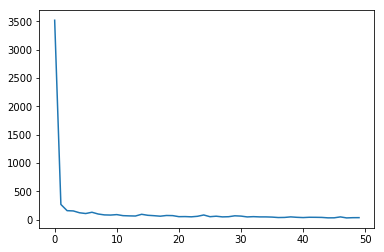

In [52]:
plt.plot(losses)